# Task_2: Quality Control 

Quality Control procedures are essential in order for GWAS analysis to generate reliable results. This step consist on removing individuals and markers with particularly high error rates. 

The steps recommended are:

1. Exclusion of SNPs:
    - Missingness
    - Hardy–Weinberg equilibrium (HWE)
    - Minor allele frequency (MAF)
2. Exclusion of individuals:
    - Missingness
    - Heterozygosity
    - Sex discrepancy
    - Relatedness
    - Population stratification
    
This task starts from a working dataset in build 37 in PLINK (v1.9) binary format.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exclusion of SNPs" data-toc-modified-id="Exclusion-of-SNPs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exclusion of SNPs</a></span></li><li><span><a href="#Exclusion of individuals" data-toc-modified-id="Exclusion-of-individuals-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exclusion of individuals</a></span></li></ul></div>

In [1]:
%load_ext rpy2.ipython

In [2]:
import os

# Create directories for the output files
path="/mnt/data/GWAS/output/build37/task2_QC"
if not os.path.exists(path):
    os.makedirs(path)
    os.makedirs(os.path.join(path,"intermediate_datasets/"))

In [3]:
# set the path where to ouput files to an environment variable
%env path=/mnt/data/GWAS/output/build37/task2_QC
%env intpath=/mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets

env: path=/mnt/data/GWAS/output/build37/task2_QC
env: intpath=/mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets


In [4]:
%%R
# Import functions for visualisation
source("scripts/QC_functions_task2.R")

## Exclusion of SNPs

### Missingness of SNPs 

SNP‐level missingness: This is the number of individuals in the sample for whom information on a specific SNP is missing. SNPs with a high level of missingness can potentially lead to bias.

We delete here those SNPs with a missingness rate greater then 5%.

In [5]:
%%bash
# Investigate missingness per individual and make histograms.
# Providing an output path is advisable. (Usage: --out output/path/filename)
plink --bfile /mnt/data/GWAS/input/dataset.b37 --missing --allow-no-sex --out $path/plink
# output: plink.imiss shows the proportion of missing individuals per SNP
# output: plink.lmiss shows the proportion of missing SNPs per individual

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/plink.log.
Options in effect:
  --allow-no-sex
  --bfile /mnt/data/GWAS/input/dataset.b37
  --missing
  --out /mnt/data/GWAS/output/build37/task2_QC/plink

257659 MB RAM detected; reserving 128829 MB for main workspace.
10048588 variants loaded from .bim file.
504 people (241 males, 263 females) loaded from .fam.
504 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 504 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998926.
--missing: Sample missing data report written to
/mnt/data

/mnt/data/GWAS/output/build37/task2_QC/plink.hh ); many commands treat these as
missing.
treat these as missing.


In [6]:
%%bash
head /mnt/data/GWAS/output/build37/task2_QC/plink.lmiss

 CHR           SNP   N_MISS   N_GENO   F_MISS
   1       1:10107        0      504        0
   1       1:10177        0      504        0
   1       1:10350        0      504        0
   1       1:10355        2      504 0.003968
   1       1:10462        0      504        0
   1       1:11008        0      504        0
   1       1:11012        0      504        0
   1       1:13110        0      504        0
   1   rs201725126        0      504        0


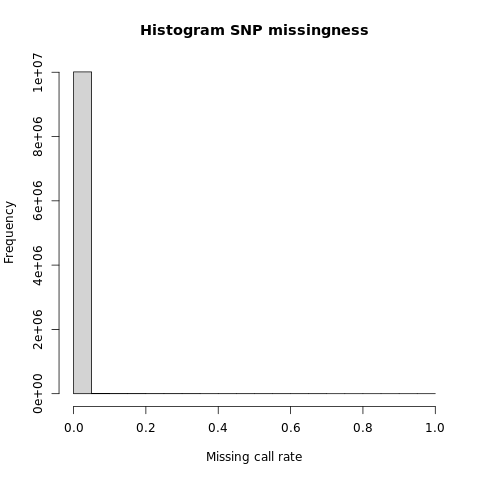

In [7]:
%%R
# Generate plots to visualize the missingness results.
# 1st parameter: optional - full path to missing data report - with no extension. (Same as --out parameter for previous plink command)
# If not provided it looks for plink.imiss and plink.lmiss in the current directory.
# 2nd parameter: option - boolean indicating whereas plots are sent to standard output 
# 3rd parameter: option - boolean indicating whereas plots are stored as pdf. (In the same directory as the input file)
snp_missingness_function(misspath="/mnt/data/GWAS/output/build37/task2_QC/plink",pdf=FALSE)

In [8]:
%%bash
# Delete SNPs with missingness >5%
plink --bfile /mnt/data/GWAS/input/dataset.b37 --geno 0.05 --make-bed --out $intpath/dataset.b37.lmiss


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.lmiss.log.
Options in effect:
  --bfile /mnt/data/GWAS/input/dataset.b37
  --geno 0.05
  --make-bed
  --out /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.lmiss

257659 MB RAM detected; reserving 128829 MB for main workspace.
10048588 variants loaded from .bim file.
504 people (241 males, 263 females) loaded from .fam.
504 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 504 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.

/mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.lmiss.hh
); many commands treat these as missing.
treat these as missing.


### Identify different genotype call rates between cases and controls

In [9]:
%%bash
# If you dont have cases and controls skip this step
plink --bfile $intpath/dataset.b37.lmiss --test-missing --out $intpath/dataset.b37.tMiss

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.tMiss.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.lmiss
  --out /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.tMiss
  --test-missing

257659 MB RAM detected; reserving 128829 MB for main workspace.
10009588 variants loaded from .bim file.
504 people (241 males, 263 females) loaded from .fam.
504 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 504 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979

/mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.tMiss.hh
); many commands treat these as missing.
treat these as missing.


In [10]:
%%bash
# The ouput file contains all SNPs with a significantly different (P <0.00001) missing data rate between cases and controls.
# 1st parameter: path to database
# 2nd parameter: output file path
perl scripts/diffmiss-qc.pl $intpath/dataset.b37 $path/fail-diffmiss-qc.txt

In [11]:
%%bash
wc -l $path/fail-diffmiss-qc.txt
cat $path/fail-diffmiss-qc.txt

0 /mnt/data/GWAS/output/build37/task2_QC/fail-diffmiss-qc.txt


**Conclusion: there are no different genotype call rates between cases and controls**

In [12]:
%%bash
# remove those SNPs
plink --bfile $intpath/dataset.b37.lmiss --make-bed --exclude $path/fail-diffmiss-qc.txt --out $intpath/dataset.b37.diffmiss
# This will not remove any SNPs but for the purpose of the tutorial we will run this line

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.diffmiss.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.lmiss
  --exclude /mnt/data/GWAS/output/build37/task2_QC/fail-diffmiss-qc.txt
  --make-bed
  --out /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.diffmiss

257659 MB RAM detected; reserving 128829 MB for main workspace.
10009588 variants loaded from .bim file.
504 people (241 males, 263 females) loaded from .fam.
504 phenotype values loaded from .fam.
--exclude: 10009588 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 504 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404

/mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.diffmiss.hh
); many commands treat these as missing.
treat these as missing.


### Hardy–Weinberg equilibrium (HWE)

This concerns the relation between the allele and genotype frequencies. Violation of the HWE law indicates that genotype frequencies are significantly different from expectations (constant over generations). This is usually the result of genotyping errors.

In [13]:
%%bash
# Check the distribution of HWE p-values of all SNPs.
plink --bfile $intpath/dataset.b37.diffmiss --hardy --out $path/plink

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/plink.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.diffmiss
  --hardy
  --out /mnt/data/GWAS/output/build37/task2_QC/plink

257659 MB RAM detected; reserving 128829 MB for main workspace.
10009588 variants loaded from .bim file.
504 people (241 males, 263 females) loaded from .fam.
504 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 504 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999872.
--hardy: Writing Hardy-Weinb

/mnt/data/GWAS/output/build37/task2_QC/plink.hh ); many commands treat these as
missing.
treat these as missing.


In [14]:
%%bash
# Selecting SNPs with HWE p-value below 0.00001, required for one of the two plot generated by the next R script, allows to zoom in on strongly deviating SNPs. 
awk '{ if ($9 <0.00001) print $0 }' $path/plink.hwe>$path/plinkzoomhwe.hwe

png 
  2 


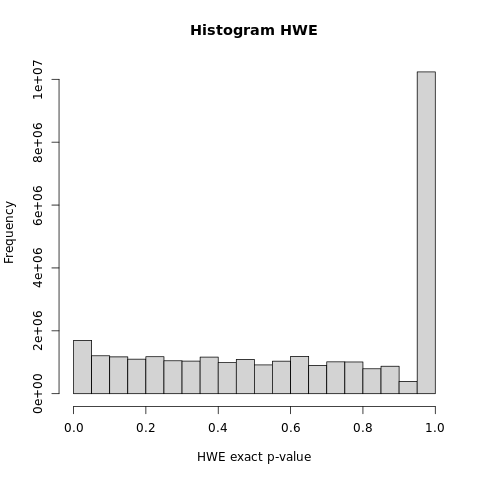

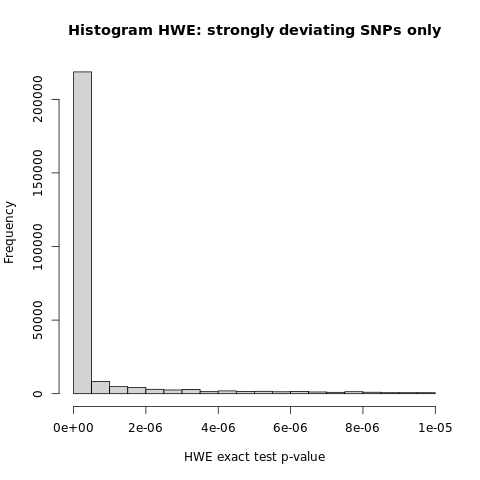

In [15]:
%%R
# Generate a histogram for HWE results.
# 1st parameter: optional - full path to hwe report. If not provided it looks for a plink.hwe file in the current directory.
# 2nd parameter: optional - full path to hew zoom file (SNPs with HWE p-value below 0.00001)
# Output pdf is stored in the same directory as the input file
hwe_function(filepath="/mnt/data/GWAS/output/build37/task2_QC/plink.hwe",zoomfilepath="/mnt/data/GWAS/output/build37/task2_QC/plinkzoomhwe.hwe")

In [16]:
%%bash
# Remove in the controls all SNPs with a HWE p-value < hwe 1e-6 
plink --bfile $intpath/dataset.b37.diffmiss --hwe 1e-6 --make-bed --out $intpath/dataset.b37.hwecontrols


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.hwecontrols.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.diffmiss
  --hwe 1e-6
  --make-bed
  --out /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.hwecontrols

257659 MB RAM detected; reserving 128829 MB for main workspace.
10009588 variants loaded from .bim file.
504 people (241 males, 263 females) loaded from .fam.
504 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 504 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858

/mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.hwecontrols.hh
); many commands treat these as missing.
treat these as missing.
chromosome.  You may want to use a less stringent --hwe p-value threshold for X
chromosome variants.


69135 variants removed due to Hardy-Weinberg exact test

### Minor allele frequency (MAF)

This is the frequency of the least often occurring allele at a specific location. It provides information to differentiate between common and rare variants (MAF<0.05) in the population.

Generate a bfile with autosomal SNPs only and delete SNPs with a low minor allele frequency (MAF). The MAF threshold should depend on your sample size, larger samples can use lower MAF thresholds. MAF > 0.01 and 0.05 are commonly used as frequency thresholds.

In [17]:
%%bash
# MAF distribution.
plink --bfile $intpath/dataset.b37.hwecontrols --freq --out $path/MAF_check

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/MAF_check.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.hwecontrols
  --freq
  --out /mnt/data/GWAS/output/build37/task2_QC/MAF_check

257659 MB RAM detected; reserving 128829 MB for main workspace.
9940453 variants loaded from .bim file.
504 people (241 males, 263 females) loaded from .fam.
504 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 504 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999872.
--freq: Allele freq

/mnt/data/GWAS/output/build37/task2_QC/MAF_check.hh ); many commands treat
these as missing.
treat these as missing.


In [18]:
%%bash
head /mnt/data/GWAS/output/build37/task2_QC/MAF_check.frq

 CHR           SNP   A1   A2          MAF  NCHROBS
   1       1:10177   AC    A       0.4058     1008
   1       1:10355    G    A      0.01793     1004
   1       1:11008    G    C      0.08829     1008
   1       1:11012    G    C      0.08829     1008
   1       1:13110    A    G      0.05655     1008
   1   rs201725126    G    T       0.1865     1008
   1   rs200579949    G    A       0.1865     1008
   1       1:13273    C    G       0.1468     1008
   1       1:14464    T    A       0.1875     1008


png 
  2 


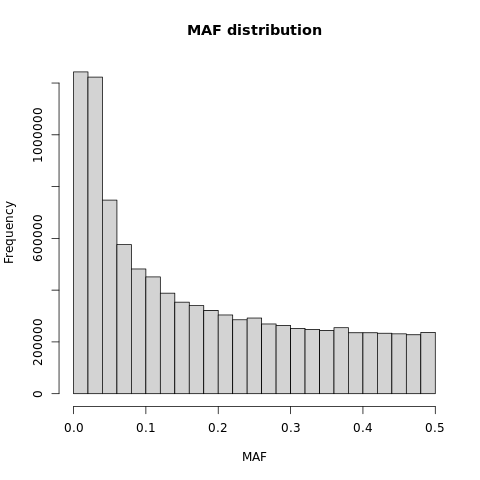

In [19]:
%%R
# Generate a plot of the MAF distribution.
maf_freq_function("/mnt/data/GWAS/output/build37/task2_QC/MAF_check.frq")

In [20]:
%%bash
# Remove SNPs with a low MAF frequency.
plink --bfile $intpath/dataset.b37.hwecontrols --maf 0.05 --make-bed --out $intpath/dataset.b37.maf5


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.maf5.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.hwecontrols
  --maf 0.05
  --make-bed
  --out /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.maf5

257659 MB RAM detected; reserving 128829 MB for main workspace.
9940453 variants loaded from .bim file.
504 people (241 males, 263 females) loaded from .fam.
504 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 504 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919

/mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.maf5.hh
); many commands treat these as missing.
treat these as missing.


**2864366 variants removed due to minor allele 0.05 threshold**

## Exclusion of individuals

### Missingness

Individual‐level missingness: This is the number of SNPs that is missing for a specific individual. High levels
of missingness can be an indication of poor DNA quality or technical problems.

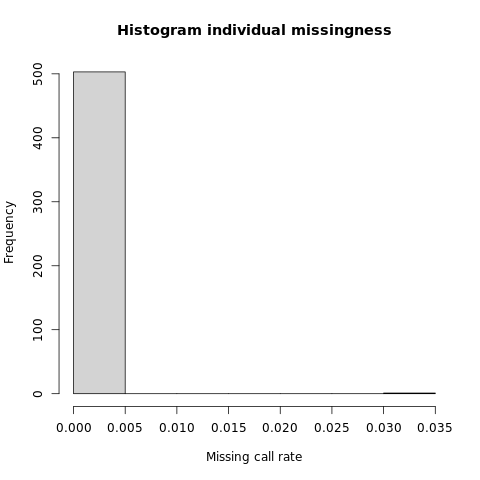

In [21]:
%%R
# Generate plots to visualize the missingness results.
# 1st parameter: optional - full path to missing data report - with no extension. (Same as --out parameter for previous plink command)
# If not provided it looks for plink.imiss and plink.lmiss in the current directory.
# 2nd parameter: option - boolean indicating whereas plots are sent to standard output 
# 3rd parameter: option - boolean indicating whereas plots are stored as pdf. (In the same directory as the input file)
ind_missingness_function(misspath="/mnt/data/GWAS/output/build37/task2_QC/plink",pdf=FALSE)

In [22]:
%%bash
# Delete individuals with missingness >0.03
plink --bfile $intpath/dataset.b37.maf5 --mind 0.03 --make-bed --out $intpath/dataset.b37.imiss


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.imiss.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.maf5
  --make-bed
  --mind 0.03
  --out /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.imiss

257659 MB RAM detected; reserving 128829 MB for main workspace.
7076087 variants loaded from .bim file.
504 people (241 males, 263 females) loaded from .fam.
504 phenotype values loaded from .fam.
1 person removed due to missing genotype data (--mind).
ID written to
/mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.imiss.irem
.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 503 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151

/mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.imiss.hh
); many commands treat these as missing.


### Heterozygosity

This is the carrying of two different alleles of a specific SNP. The heterozygosity rate of an individual is the proportion of heterozygous genotypes. High levels of heterozygosity within an individual might be an indication of low sample quality whereas low levels of heterozygosity may be due to inbreeding.

Generate a plot of the distribution of the heterozygosity rate of your subjects. And remove individuals with a heterozygosity rate deviating more than 3 sd from the mean.

In [23]:
%%bash
# Checks for heterozygosity are performed on a set of SNPs which are not highly correlated.
# Therefore, to generate a list of non-(highly)correlated SNPs, we exclude high inversion regions (inversion.txt [High LD regions]) and prune the SNPs using the command --indep-pairwise.
# The parameters 50 5 0.2 stand respectively for: the window size, the number of SNPs to shift the window at each step, and the multiple correlation coefficient for a SNP being regressed on all other SNPs simultaneously.
plink --bfile $intpath/dataset.b37.imiss --exclude /mnt/data/GWAS/ref_files/inversion.txt --range --indep-pairwise 50 5 0.2 --out $path/indepSNP
# Note, don't delete the file indepSNP.prune.in, we will use this file in later steps of the tutorial.

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/indepSNP.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.imiss
  --exclude /mnt/data/GWAS/ref_files/inversion.txt
  --indep-pairwise 50 5 0.2
  --out /mnt/data/GWAS/output/build37/task2_QC/indepSNP
  --range

Note: --range flag deprecated.  Use e.g. '--extract range [filename]'.
257659 MB RAM detected; reserving 128829 MB for main workspace.
7076087 variants loaded from .bim file.
503 people (240 males, 263 females) loaded from .fam.
503 phenotype values loaded from .fam.
--exclude range: 71281 variants excluded.
--exclude range: 7004806 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 503 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314

/mnt/data/GWAS/output/build37/task2_QC/indepSNP.hh ); many commands treat these
as missing.


In [24]:
%%bash
# This file contains your pruned data set in order to plot the heterozygosity rate distribution in the next step
plink --bfile $intpath/dataset.b37.imiss --extract $path/indepSNP.prune.in --het --out $path/R_check

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/R_check.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.imiss
  --extract /mnt/data/GWAS/output/build37/task2_QC/indepSNP.prune.in
  --het
  --out /mnt/data/GWAS/output/build37/task2_QC/R_check

257659 MB RAM detected; reserving 128829 MB for main workspace.
7076087 variants loaded from .bim file.
503 people (240 males, 263 females) loaded from .fam.
503 phenotype values loaded from .fam.
--extract: 473808 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 503 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081

/mnt/data/GWAS/output/build37/task2_QC/R_check.hh ); many commands treat these
as missing.


png 
  2 


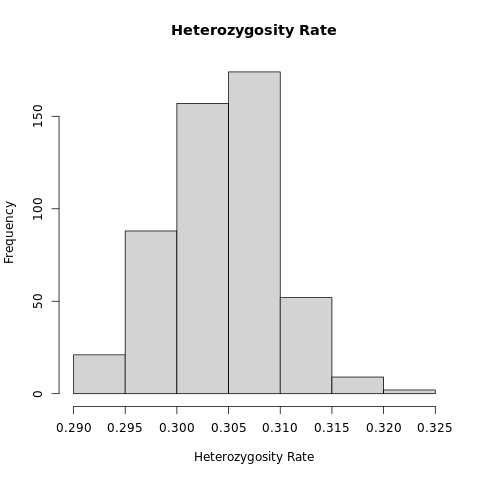

In [25]:
%%R
# Plot of the heterozygosity rate distribution
het_function("/mnt/data/GWAS/output/build37/task2_QC/R_check.het")

In [26]:
%%R
# The following code generates a list of individuals who deviate more than 3 standard deviations from the heterozygosity rate mean.
# This outputs the file fail-het-qc.txt
het_outliers_list_function("/mnt/data/GWAS/output/build37/task2_QC/R_check.het")

In [27]:
%%bash
wc -l $path/fail-het-qc.txt
cat $path/fail-het-qc.txt

3 /mnt/data/GWAS/output/build37/task2_QC/fail-het-qc.txt
"FID" "IID" "O.HOM." "E.HOM." "N.NM." "F" "HET_RATE" "HET_DST"
"HGX01756" "HGX01756" 308976 319100 454785 -0.07463 0.320610838088327 3.09456406687962
"HGX01761" "HGX01761" 307925 319100 454803 -0.08247 0.32294861731343 3.53769820197418


In [28]:
%%bash
# Adapt this file to make it compatible for PLINK, by removing all quotation marks from the file and selecting only the first two columns.
sed 's/"// g' $path/fail-het-qc.txt | awk '{print$1, $2}'> $path/het_fail_ind.txt

# Remove heterozygosity rate outliers.
plink --bfile $intpath/dataset.b37.imiss --remove $path/het_fail_ind.txt --make-bed --out $intpath/dataset.b37.het


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.het.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.imiss
  --make-bed
  --out /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.het
  --remove /mnt/data/GWAS/output/build37/task2_QC/het_fail_ind.txt

257659 MB RAM detected; reserving 128829 MB for main workspace.
7076087 variants loaded from .bim file.
503 people (240 males, 263 females) loaded from .fam.
503 phenotype values loaded from .fam.
--remove: 501 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 501 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525

/mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.het.hh
); many commands treat these as missing.


### Sex discrepancy

This is the difference between the assigned sex and the sex determined based on the genotype. A discrepancy likely points to sample mix‐ups in the lab. Note, this test can only be conducted when SNPs 
on the sex chromosomes (X and Y) have been assessed.

In [29]:
%%bash
# Females have a F value of <0.2, and males must have a F value >0.8. This F value is based on the X chromosome inbreeding (homozygosity) estimate.
# Subjects who do not fulfil these requirements are flagged "PROBLEM" by PLINK.
# If your DB has been already splitted, skip the first step
plink --bfile $intpath/dataset.b37.het --split-x 2699520 154931044 no-fail --make-bed --out $intpath/dataset.b37.splitted
#plink --bfile $intpath/dataset.b37.imiss --check-sex --out $path/plink
plink --bfile $intpath/dataset.b37.splitted --check-sex --out $path/plink

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.splitted.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.het
  --make-bed
  --out /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.splitted
  --split-x 2699520 154931044 no-fail

257659 MB RAM detected; reserving 128829 MB for main workspace.
7076087 variants loaded from .bim file.
501 people (238 males, 263 females) loaded from .fam.
501 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 501 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879

/mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.splitted.hh
); many commands treat these as missing.
/mnt/data/GWAS/output/build37/task2_QC/plink.hh ); many commands treat these as
missing.


**4 problems detected**

png 
  2 


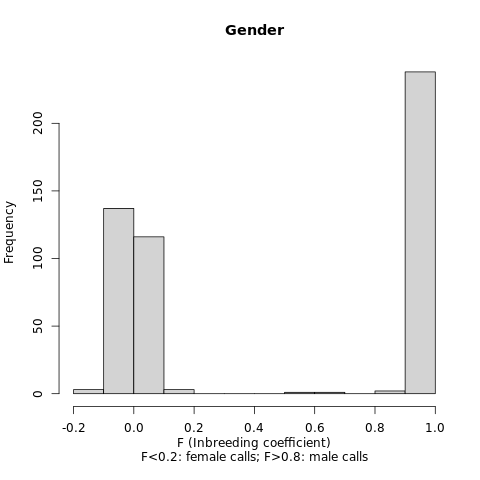

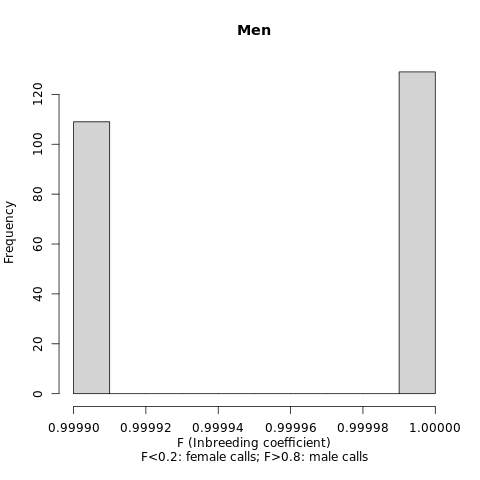

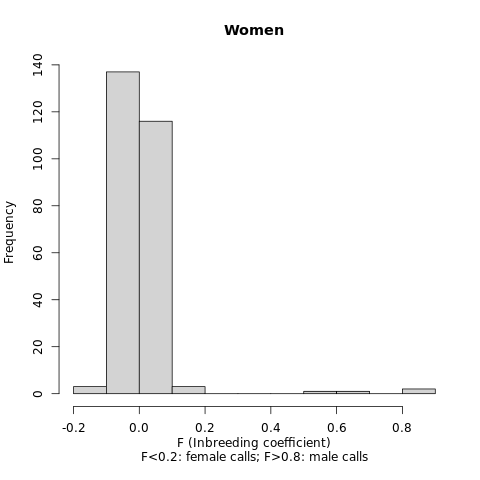

In [30]:
%%R
# Generate plots to visualize the sex-check results.
gender_check_function("/mnt/data/GWAS/output/build37/task2_QC/plink.sexcheck")

In [31]:
%%bash
# Individuals with sex discrepancy.
grep "PROBLEM" $path/plink.sexcheck

  HGX00361   HGX00361            2            0      PROBLEM       0.6966
  NAX20506   NAX20506            2            1      PROBLEM       0.8885
  NAX20530   NAX20530            2            1      PROBLEM       0.8627
  NAX20533   NAX20533            2            0      PROBLEM       0.5048


In [32]:
%%bash
# Delete individuals with sex discrepancy.
grep "PROBLEM" $path/plink.sexcheck| awk '{print$1,$2}'> $path/sex_discrepancy.txt # This command generates a list of individuals with the status PROBLEM.

# This command removes the list of individuals with the status PROBLEM.
plink --bfile $intpath/dataset.b37.het --remove $path/sex_discrepancy.txt --make-bed --out $intpath/dataset.b37.sex 

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.sex.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.het
  --make-bed
  --out /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.sex
  --remove /mnt/data/GWAS/output/build37/task2_QC/sex_discrepancy.txt

257659 MB RAM detected; reserving 128829 MB for main workspace.
7076087 variants loaded from .bim file.
501 people (238 males, 263 females) loaded from .fam.
501 phenotype values loaded from .fam.
--remove: 497 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 497 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152

/mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.sex.hh
); many commands treat these as missing.


### Relatedness

This indicates how strongly a pair of individuals is genetically related. A conventional GWAS assumes that all subjects are unrelated. The inclusion of relatives could lead to biased estimations of standard errors of SNP effect sizes.

We are going to exclude all individuals above the pihat threshold of 0.1875.

In [33]:
%%bash
#Generate pair-wise IBS for all pairs of individuals in the study based on the reduced marker set.
plink --bfile $intpath/dataset.b37.sex  --extract $path/indepSNP.prune.in --genome --out $path/checkIBS --missing

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/checkIBS.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.sex
  --extract /mnt/data/GWAS/output/build37/task2_QC/indepSNP.prune.in
  --genome
  --missing
  --out /mnt/data/GWAS/output/build37/task2_QC/checkIBS

257659 MB RAM detected; reserving 128829 MB for main workspace.
7076087 variants loaded from .bim file.
497 people (238 males, 259 females) loaded from .fam.
497 phenotype values loaded from .fam.
--extract: 473808 variants remaining.
Using up to 4 threads (change this with --threads).
Before main variant filters, 497 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757

/mnt/data/GWAS/output/build37/task2_QC/checkIBS.hh ); many commands treat these
as missing.


In [34]:
%%bash
# Write only IBS for related individuals (pihat>0.1875)
plink --bfile $intpath/dataset.b37.sex  --min 0.1875 --extract $path/indepSNP.prune.in --genome --out $path/pihat_min --missing

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/pihat_min.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.sex
  --extract /mnt/data/GWAS/output/build37/task2_QC/indepSNP.prune.in
  --genome
  --min 0.1875
  --missing
  --out /mnt/data/GWAS/output/build37/task2_QC/pihat_min

257659 MB RAM detected; reserving 128829 MB for main workspace.
7076087 variants loaded from .bim file.
497 people (238 males, 259 females) loaded from .fam.
497 phenotype values loaded from .fam.
--extract: 473808 variants remaining.
Using up to 4 threads (change this with --threads).
Before main variant filters, 497 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667

/mnt/data/GWAS/output/build37/task2_QC/pihat_min.hh ); many commands treat
these as missing.


In [35]:
%%bash
wc -l $path/pihat_min.genome
cat $path/pihat_min.genome

2 /mnt/data/GWAS/output/build37/task2_QC/pihat_min.genome
      FID1      IID1      FID2      IID2 RT    EZ      Z0      Z1      Z2  PI_HAT PHE       DST     PPC   RATIO
  HGX00116  HGX00116  HGX00120  HGX00120 UN    NA  0.6127  0.3873  0.0000  0.1937  -1  0.788899  1.0000  3.5811


png 
  2 


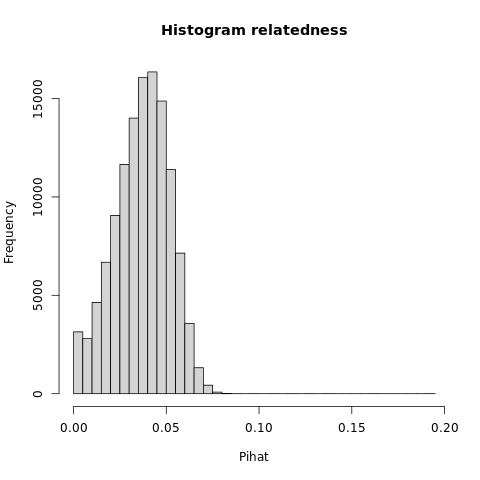

In [36]:
%%R
# Generate a plot to assess the type of relationship.
relatedness_function("/mnt/data/GWAS/output/build37/task2_QC/checkIBS.genome")

**Generate a list of FID and IID of the individual(s) with the lowest call rate in 'related' pairs - Pihat above 0.1875.**

In [37]:
%%bash 
# Identifies the individual(s) with the lowest call rate in 'related' pairs with the lower call rate
# 1st parameter: lmiss file from previous step
# 2nd parameter: genome file from previous step
# 3rd parameter: Pihat threshold
# 4th parameter: output file
perl scripts/IBD_list.pl $path/checkIBS.imiss $path/checkIBS.genome 0.1875 $path/fail-IBD-QC.txt
wc -l $path/fail-IBD-QC.txt
cat $path/fail-IBD-QC.txt

Reading PLINK .imiss file /mnt/data/GWAS/output/build37/task2_QC/checkIBS.imiss
Reading PLINK .genome file /mnt/data/GWAS/output/build37/task2_QC/checkIBS.imiss
1 /mnt/data/GWAS/output/build37/task2_QC/fail-IBD-QC.txt
HGX00116 HGX00116


In [38]:
%%bash
# Delete those individuals
plink --bfile $intpath/dataset.b37.sex --remove $path/fail-IBD-QC.txt --make-bed --out $intpath/dataset.b37.IBD


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.IBD.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.sex
  --make-bed
  --out /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.IBD
  --remove /mnt/data/GWAS/output/build37/task2_QC/fail-IBD-QC.txt

257659 MB RAM detected; reserving 128829 MB for main workspace.
7076087 variants loaded from .bim file.
497 people (238 males, 259 females) loaded from .fam.
497 phenotype values loaded from .fam.
--remove: 496 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 496 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354

/mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.IBD.hh
); many commands treat these as missing.


 **For the next step, population stratification, you need the following files:**
 - The bfile /mnt/data/GWAS/output/build37/task2_QC/intermediate_datasets/dataset.b37.IBD (.fam,.bed, and .bim)
 - /mnt/data/GWAS_data/indepSNP.prune.in